In [1]:
# --- Instalasi Library ---
!pip install annoy
!pip install faiss-cpu # atau faiss-gpu jika Anda memiliki GPU NVIDIA dan CUDA
!pip install hnswlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551811 sha256=e7b2f2a20c65b7024bcf4403dfe5a8dfef5935ca2bad45be3d3c1015616a322b
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 62.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp312-cp312-linux_x86_64.whl size=2528144 sha256=465b624e463244ef9c951c817952ba024a3df70af39d2fee01b1aa68f2795a0b
  Stored in directory: /root/.cache/pip/wheels/ac/39/b3/cbd7f9cbb76501d2d5fbc84956e70d0b94e788aac87bda465e
Successfully built hnswlib


In [8]:
# --- Import Library dan Fungsi Bantuan ---
import numpy as np
import time
from annoy import AnnoyIndex
import faiss
import hnswlib
import matplotlib.pyplot as plt
import os


===== Metric: EUCLIDEAN =====

Data: 1,000 points | Dim: 2D
ANNOY time: 0.0242s
FAISS time: 0.0005s
HNSW time: 0.0335s

Data: 1,000 points | Dim: 5D
ANNOY time: 0.0153s
FAISS time: 0.0002s
HNSW time: 0.0357s

Data: 1,000,000 points | Dim: 2D
ANNOY time: 29.1604s
FAISS time: 0.0607s
HNSW time: 59.2435s

Data: 1,000,000 points | Dim: 5D
ANNOY time: 22.3429s
FAISS time: 0.1335s
HNSW time: 100.2049s

===== Metric: ANGULAR =====

Data: 1,000 points | Dim: 2D
ANNOY time: 0.0472s
FAISS time: 0.0003s
HNSW time: 0.0270s

Data: 1,000 points | Dim: 5D
ANNOY time: 0.0196s
FAISS time: 0.0002s
HNSW time: 0.0370s

Data: 1,000,000 points | Dim: 2D
ANNOY time: 92.1605s
FAISS time: 0.0744s
HNSW time: 107.5780s

Data: 1,000,000 points | Dim: 5D
ANNOY time: 29.8933s
FAISS time: 0.1421s
HNSW time: 91.6543s

=== Summary Table ===
      Metric        N  Dim      Annoy     Faiss        HNSW
0  euclidean     1000    2   0.024201  0.000491    0.033538
1  euclidean     1000    5   0.015310  0.000178    0.035659

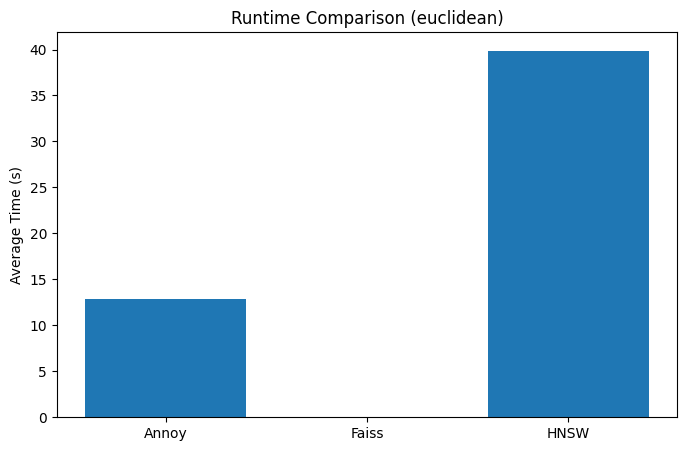

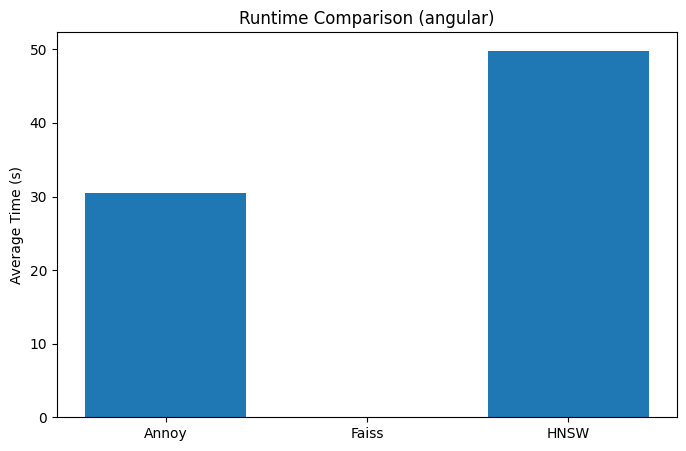

In [7]:
# Helper function to generate random dataset
def generate_data(n_points, dim):
    return np.random.random((n_points, dim)).astype('float32')

# Helper function for timing
def timer(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        return result, time.time() - start
    return wrapper

# ANNOY
@timer
def run_annoy(data, query, metric='euclidean', n_trees=10, k=5):
    dim = data.shape[1]
    index = AnnoyIndex(dim, metric)
    for i, v in enumerate(data):
        index.add_item(i, v)
    index.build(n_trees)
    neighbors = [index.get_nns_by_vector(q, k) for q in query]
    return neighbors

# FAISS
@timer
def run_faiss(data, query, metric='l2', k=5):
    dim = data.shape[1]
    if metric == 'l2':
        index = faiss.IndexFlatL2(dim)
    else:
        index = faiss.IndexFlatIP(dim)
        faiss.normalize_L2(data)
        faiss.normalize_L2(query)
    index.add(data)
    D, I = index.search(query, k)
    return I

# HNSW
@timer
def run_hnsw(data, query, metric='l2', k=5):
    dim = data.shape[1]
    space = 'l2' if metric == 'l2' else 'cosine'
    index = hnswlib.Index(space=space, dim=dim)
    index.init_index(max_elements=len(data), ef_construction=100, M=16)
    index.add_items(data)
    index.set_ef(50)
    labels, distances = index.knn_query(query, k=k)
    return labels


# EXPERIMENT CONFIG
configs = [
    (1000, 2),
    (1000, 5),
    (1_000_000, 2),
    (1_000_000, 5)
]

results = []

# RUN EXPERIMENT
for metric in ['euclidean', 'angular']:
    print(f"\n===== Metric: {metric.upper()} =====")
    for n_points, dim in configs:
        data = generate_data(n_points, dim)
        query = generate_data(10, dim)

        print(f"\nData: {n_points:,} points | Dim: {dim}D")

        # ANNOY
        _, t_annoy = run_annoy(data, query, metric=metric)
        print(f"ANNOY time: {t_annoy:.4f}s")

        # FAISS
        metric_faiss = 'l2' if metric == 'euclidean' else 'ip'
        _, t_faiss = run_faiss(data, query, metric=metric_faiss)
        print(f"FAISS time: {t_faiss:.4f}s")

        # HNSW
        metric_hnsw = 'l2' if metric == 'euclidean' else 'cosine'
        _, t_hnsw = run_hnsw(data, query, metric=metric_hnsw)
        print(f"HNSW time: {t_hnsw:.4f}s")

        results.append([metric, n_points, dim, t_annoy, t_faiss, t_hnsw])

# VISUALIZE RESULTS
import pandas as pd
df = pd.DataFrame(results, columns=["Metric", "N", "Dim", "Annoy", "Faiss", "HNSW"])

print("\n=== Summary Table ===")
print(df)

for metric in df['Metric'].unique():
    subset = df[df['Metric'] == metric]
    plt.figure(figsize=(8,5))
    plt.title(f"Runtime Comparison ({metric})")
    plt.bar(["Annoy", "Faiss", "HNSW"], subset[["Annoy", "Faiss", "HNSW"]].mean())
    plt.ylabel("Average Time (s)")
    plt.show()